<a id='pred_top'>

# Predict auction price

Try several models and improve predicition accuracy

## Model fitting

- Linear fits  
  1. [Simple linear fit](#pred_model_1)  
     No cross validation. Observations with missing values are dropped.
  2. [Dependent values scaled](#pred_model_2)  
     Dependent value here is _prices_.
  3. [Partial data](#pred_model_3)  
     Only young cars
- Multiple linear regression models  
  1. [MLR fit without imputation](#pred_model_4)  
  2. [With imputation](#pred_model_5)  
  3. [Include categorical features](#pred_model_6)  
  4. [Lasso regularization](#pred_model_7)  
  5. [include engineered features](#pred_model_8) **TODO**  

## Results

- [Model performance](#pred_accuracies)
- [Save best model](#pred_save_model) **TODO**  
  This is not implemented yet. Some preprocessing functions are not handled well with `pickle`.
- [Predictions](#pred_predict)
     
  

In [1]:
import drz_config
cfg = drz_config.read_config()
VERBOSE = cfg['VERBOSE']
SKIPSAVE = cfg['SKIPSAVE']

if VERBOSE > 0:
    display(cfg)

{'settings_fn': '../code/assets/drz-auction-settings.ini',
 'DATE': '2021-05',
 'VERBOSE': 1,
 'OPBOD': False,
 'URL': 'http://verkoop.domeinenrz.nl/verkoop_bij_inschrijving_2021-0005',
 'EXTEND_URL': False,
 'CLOSEDDATA': True,
 'closed_data_fields': '*',
 'SKIPSAVE': False}

In [2]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

In [3]:
# set figure defaults (needs to be in cell seperate from import sns)
plt.style.use(['default', '../assets/movshon.mplstyle', '../assets/context-notebook.mplstyle'])

# Load data

In [4]:
fn = '../data/cars-for-ml.pkl'
print(fn)
df = pd.read_pickle(fn)

# categories
cat_columns = ['brand', 'model', 'fuel', 'body_type','color', 'energy_label', 'fwd', 'automatic_gearbox', 'under_survey']
# numerical
num_columns = list(np.setdiff1d(df.columns, cat_columns + ['price']))

# Factorized categorical values
fld = 'energy_label'
# replace empty with NaN creates factor '-1'
v, idx = pd.factorize(df[fld].replace({'': np.NaN}), sort=True)
# convert '-1' back to NaN
v = v.astype(float)
v[v==-1] = np.NaN
# Store in dataframe
new_col = 'converted_' + fld
df[new_col] = v
# update list
num_columns += [new_col]
cat_columns.remove(fld)
print('\nCategorical field [{}] is converted to sequential numbers with: '.format(fld), end='\n\t')
print(*['{} <'.format(c) for c in idx], end='\n\n')

# convert boolean to string
for fld in ['fwd', 'automatic_gearbox', 'under_survey']:
    if fld not in df.columns:
        print(f'!{fld} not in data!. Skip for now')
        continue
    new_col = fld
    # # update list
    # cat_columns += [new_col]
    # cat_columns.remove(fld)
    replace_dict = {
        '': '', 
        True: 'y', 
        False: 'n'
    }
    df[new_col] = df[fld].replace(replace_dict)
    print('\nBoolean field [{}] is converted to numbers according to: '.format(fld), end='\n')
    print(*['\t"{}" -> {} ({})\n'.format(k,v, type(v)) for k,v in replace_dict.items()], end='\n\n')

# convert integer to float and replace -1
for fld in ['number_of_cylinders', 'number_of_doors', 'number_of_gears', 'number_of_seats']:
    if fld not in df.columns:
        print(f'!{fld} not in data!. Skip for now')
        continue
    new_col = fld
    replace_dict = {
        -1: np.NaN, 
    }
    df[new_col] = df[fld].replace(replace_dict).astype(float)

# convert empty string to NaN
for fld in ['brand', 'model', 'fuel', 'body_type', 'color', 'fwd']:
    if fld not in df.columns:
        print(f'!{fld} not in data!. Skip for now')
        continue
    new_col = fld
    replace_dict = {
        '': np.NaN, 
    }
    df[new_col] = df[fld].replace(replace_dict)

# translate Dutch to English
fld = 'color'
new_col = fld
# # update list
# cat_columns += [new_col]
# cat_columns.remove(fld)
replace_dict = {
    '': 'missing', 
    'BLAUW': 'Blue',
    'ROOD': 'Red',
    'GROEN': 'Green',
    'GRIJS': 'Gray',
    'WIT': 'White',
    'ZWART': 'Black',
    'BEIGE': 'Beige',
    'BRUIN': 'Brown',
    'ROSE': 'Pink',
    'GEEL': 'Yellow',
    'CREME': 'Creme',
    'ORANJE': 'Orange',
    'PAARS': 'Purple,'
}
df[new_col] = df[fld].replace(replace_dict)
print('\nField [{}] is converted according to: '.format(fld), end='\n')
print(*['\t"{}" -> {} ({})\n'.format(k,v, type(v)) for k,v in replace_dict.items()], end='\n\n')

# reporting
try:
    print('Categorical:', len(cat_columns))
    [print('\t[{:2.0f}] {:s}'.format(i+1, c)) for i,c in enumerate(df[cat_columns].columns)]
    print('Numercial:', len(num_columns))
    [print('\t[{:2.0f}] {:s}'.format(i+1, c)) for i,c in enumerate(df[num_columns].columns)]
    print('Last lot in data set:\n\t{}'.format(df.index[-1]))
except:
    cat_columns = [c for c in cat_columns if c in df.columns]
    num_columns = [c for c in num_columns if c in df.columns]    
    print('! not all fields are in data !. Skip for now')

../data/cars-for-ml.pkl

Categorical field [energy_label] is converted to sequential numbers with: 
	A < B < C < D < E < F < G <


Boolean field [fwd] is converted to numbers according to: 
	"" ->  (<class 'str'>)
 	"True" -> y (<class 'str'>)
 	"False" -> n (<class 'str'>)



Boolean field [automatic_gearbox] is converted to numbers according to: 
	"" ->  (<class 'str'>)
 	"True" -> y (<class 'str'>)
 	"False" -> n (<class 'str'>)



Boolean field [under_survey] is converted to numbers according to: 
	"" ->  (<class 'str'>)
 	"True" -> y (<class 'str'>)
 	"False" -> n (<class 'str'>)



Field [color] is converted according to: 
	"" -> missing (<class 'str'>)
 	"BLAUW" -> Blue (<class 'str'>)
 	"ROOD" -> Red (<class 'str'>)
 	"GROEN" -> Green (<class 'str'>)
 	"GRIJS" -> Gray (<class 'str'>)
 	"WIT" -> White (<class 'str'>)
 	"ZWART" -> Black (<class 'str'>)
 	"BEIGE" -> Beige (<class 'str'>)
 	"BRUIN" -> Brown (<class 'str'>)
 	"ROSE" -> Pink (<class 'str'>)
 	"GEEL" -> Yellow (<class

In [5]:
# Store model results in dictonary: Instantiate empty dict
models = dict()

<H1><a href="#pred_top">^</a></H1><a id='pred_model_1'>

- - - - - 
# Model: Simple linear fit
Regress age (in days) with price (euro).  

## >> BIG FAT WARNING <<
All data is used without train / test split. I.e. accuracy is based on data that was used for fit. This is considered bad practice!

## Prepare input

In [6]:
from sklearn import linear_model

model_name = 'linear regression no cv'

X = df.dropna(subset=['price','age']).age.values.reshape(-1,1)
y = df.dropna(subset=['price','age']).price.values.reshape(-1,1)
print(X.shape)
print(y.shape)

(5646, 1)
(5646, 1)


## Fit

In [7]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# create regression model object and store
reg = linear_model.LinearRegression()
models[model_name].update({'model':reg})

# fit
reg.fit(X,y) # fit with all data
models[model_name].update({'n':y.shape[0]})

# parameters
betas = [*reg.intercept_, *reg.coef_[0]]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})

../results/linear_regression_no_cv.png


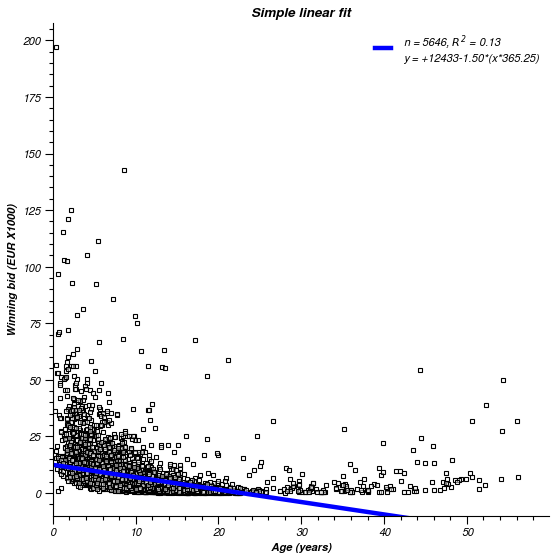

In [8]:
# Fit a line by using predict
prediction_X = np.array([0,int(np.ceil(X.max()/365.25))*365.25]).reshape(-1,1)
prediction_y = reg.predict(prediction_X)

# plot
plt.figure(figsize=[8,8])
plt.plot(X/365.25, y/1000, marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4)
hdl_fit = plt.plot(prediction_X/365, prediction_y/1000, color='blue', marker=None, linestyle='-', linewidth=4)
plt.legend(hdl_fit, ['n = {}, $R^2$ = {:.2f}\ny = {:+.0f}{:+.2f}*(x*365.25)'.format(
    models[model_name]['n'],
    models[model_name]['R^2'],
    *models[model_name]['betas']
)], loc='upper right')
plt.xlabel('Age (years)', style='italic')
plt.ylabel('Winning bid (EUR X1000)', style='italic')
plt.title('Simple linear fit', style='italic')
plt.ylim(bottom = -10)
plt.xlim(left = 0)

# Save
file_name = '../results/{}.png'.format(model_name.replace(' ','_'))
if (SKIPSAVE==False): #and (not(os.path.isfile(file_name))):
    print(file_name)
    with plt.style.context('../assets/context-paper.mplstyle'):
        plt.savefig(file_name, bbox_inches='tight', transparent=True)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')

<H1><a href="#pred_top">^</a></H1><a id='pred_model_2'> 

## Model: linear but with scaled dependent values (prices)

Instead of using all data **train/test split** is performed. Also prices are log transformed.  

## Prepare input

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score

model_name = 'linear regression log price'

X = df.dropna(subset=['price','age']).age.values.reshape(-1,1)
y = np.log10(df.dropna(subset=['price','age']).price.values.reshape(-1,1))
print(X.shape)
print(y.shape)

(5646, 1)
(5646, 1)


## Fit

In [10]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

# create regression model object and store
reg = linear_model.LinearRegression()
models[model_name].update({'model':reg})

# fit
reg.fit(X_train,y_train) # fit with training set
models[model_name].update({'n':y.shape[0]})

# parameters
betas = [*reg.intercept_, *reg.coef_[0]]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})
models[model_name].update({'test R^2':reg.score(X_test,y_test)})
cv_results = cross_val_score(reg, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})


(3952, 1)
(1694, 1)


In [11]:
depr_half_n_days = -(np.log10(2)/models[model_name]['betas'][1])
print('According to "{}"-model'.format(model_name))
print('Car depreciates to half its value every\n\t{:.0f} days ({:.1f} years).'.format(depr_half_n_days, depr_half_n_days/365.25))
for y in [0,2,4,6,8]:
    print('\ty(t={:+5.0f}) = {:.0f} euro'.format(y, 10**reg.predict([[y*365.25]])[0][0]))
print('\n\ty(t={:+5.1f}) = {:.0f} euro'.format(depr_half_n_days/365.25, 10**reg.predict([[depr_half_n_days]])[0][0]))
print('\ty(t=0) / 2 = {:.0f} euro'.format(10**models[model_name]['betas'][0]/2))

According to "linear regression log price"-model
Car depreciates to half its value every
	2410 days (6.6 years).
	y(t=   +0) = 9600 euro
	y(t=   +2) = 7781 euro
	y(t=   +4) = 6306 euro
	y(t=   +6) = 5111 euro
	y(t=   +8) = 4142 euro

	y(t= +6.6) = 4800 euro
	y(t=0) / 2 = 4800 euro


../results/linear_regression_log_price.png


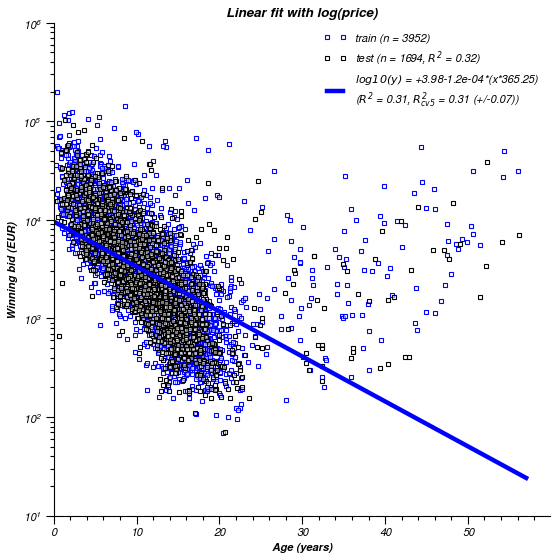

In [12]:
# Fit a line by using predict
prediction_X = np.array([0,int(np.ceil(X.max()/365.25))*365.25]).reshape(-1,1)
prediction_y = reg.predict(prediction_X)

# plot
plt.figure(figsize=[8,8])
hdl_trn = plt.plot(X_train/365.25, np.power(10,y_train), marker='s', markeredgecolor = (0, 0, 1, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4, 
                   label='train (n = {})'.format(y_train.shape[0]))
hdl_tst = plt.plot(X_test/365.25, np.power(10,y_test), marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4, 
                   label='test (n = {}, $R^2$ = {:.2f})'.format(
                       y_test.shape[0],
                       models[model_name]['test R^2'],
                   ))
hdl_fit = plt.plot(prediction_X/365, np.power(10,prediction_y), color='blue', marker=None, linestyle='-', linewidth=4, 
                   label = '$log10(y)$ = {:+.2f}{:+.1e}*(x*365.25)\n($R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f}))'.format(
                       *models[model_name]['betas'],
                       models[model_name]['R^2'],
                       models[model_name]['cv R^2'].shape[0],
                       np.mean(models[model_name]['cv R^2']),
                       np.std(models[model_name]['cv R^2']),
                   ))
plt.legend()
plt.xlabel('Age (years)', style='italic')
plt.ylabel('Winning bid (EUR)', style='italic')
plt.title('Linear fit with log(price)', style='italic')
plt.ylim(bottom = 10, top = 1000000)
plt.xlim(left = 0)
plt.yscale('log')

# Save
file_name = '../results/{}.png'.format(model_name.replace(' ','_'))
if (SKIPSAVE==False): #and (not(os.path.isfile(file_name))):
    print(file_name)
    with plt.style.context('../assets/context-paper.mplstyle'):
        plt.savefig(file_name, bbox_inches='tight', transparent=True)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')

<H1><a href="#pred_top">^</a></H1><a id='pred_model_3'> 

## Model: scaled price, but only young cars

Same as [model 2](#pred_model_2), but ignore cars older than 25y

## Prepare input

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score

model_name = 'linear regression log price young'

is_yng = df.age/365.25 < 25

X = df[is_yng].dropna(subset=['price','age']).age.values.reshape(-1,1)
y = np.log10(df[is_yng].dropna(subset=['price','age']).price.values.reshape(-1,1))
print(X.shape)
print(y.shape)

(5495, 1)
(5495, 1)


## Fit

In [14]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

# create regression model object and store
reg = linear_model.LinearRegression()
models[model_name].update({'model':reg})

# fit
reg.fit(X_train,y_train)
models[model_name].update({'n':y.shape[0]})

# parameters
betas = [*reg.intercept_, *reg.coef_[0]]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})
models[model_name].update({'test R^2':reg.score(X_test,y_test)})
cv_results = cross_val_score(reg, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})


(3846, 1)
(1649, 1)


In [15]:
depr_half_n_days = -(np.log10(2)/models[model_name]['betas'][1])
print('According to "{}"-model'.format(model_name))
print('Car depreciates to half its value every\n\t{:.0f} days ({:.1f} years).'.format(depr_half_n_days, depr_half_n_days/365.25))
for y in [0,2,4,6,8]:
    print('\ty(t={:+5.0f}) = {:.0f} euro'.format(y, 10**reg.predict([[y*365.25]])[0][0]))
print('\n\ty(t={:+5.1f}) = {:.0f} euro'.format(depr_half_n_days/365.25, 10**reg.predict([[depr_half_n_days]])[0][0]))
print('\ty(t=0) / 2 = {:.0f} euro'.format(10**models[model_name]['betas'][0]/2))

According to "linear regression log price young"-model
Car depreciates to half its value every
	1287 days (3.5 years).
	y(t=   +0) = 24007 euro
	y(t=   +2) = 16198 euro
	y(t=   +4) = 10929 euro
	y(t=   +6) = 7374 euro
	y(t=   +8) = 4975 euro

	y(t= +3.5) = 12004 euro
	y(t=0) / 2 = 12004 euro


../results/linear_regression_log_price_young.png


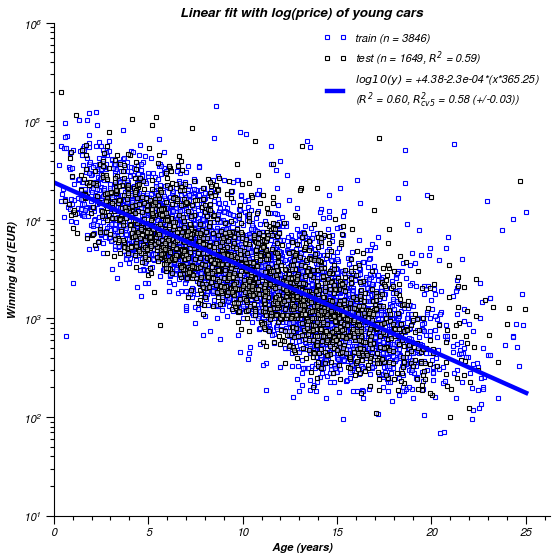

In [16]:
# Fit a line by using predict
prediction_X = np.array([0,int(np.ceil(X.max()/365.25))*365.25]).reshape(-1,1)
prediction_y = reg.predict(prediction_X)

# plot
plt.figure(figsize=[8,8])
hdl_trn = plt.plot(X_train/365.25, np.power(10,y_train), marker='s', markeredgecolor = (0, 0, 1, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4, 
                   label='train (n = {})'.format(y_train.shape[0]))
hdl_tst = plt.plot(X_test/365.25, np.power(10,y_test), marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4, 
                   label='test (n = {}, $R^2$ = {:.2f})'.format(
                       y_test.shape[0],
                       models[model_name]['test R^2'],
                   ))
hdl_fit = plt.plot(prediction_X/365, np.power(10,prediction_y), color='blue', marker=None, linestyle='-', linewidth=4, 
                   label = '$log10(y)$ = {:+.2f}{:+.1e}*(x*365.25)\n($R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f}))'.format(
                       *models[model_name]['betas'],
                       models[model_name]['R^2'],
                       models[model_name]['cv R^2'].shape[0],
                       np.mean(models[model_name]['cv R^2']),
                       np.std(models[model_name]['cv R^2']),
                   ))
plt.legend()
plt.xlabel('Age (years)', style='italic')
plt.ylabel('Winning bid (EUR)', style='italic')
plt.title('Linear fit with log(price) of young cars', style='italic')
plt.ylim(bottom = 10, top = 1000000)
plt.xlim(left = 0)
plt.yscale('log')

# Save
file_name = '../results/{}.png'.format(model_name.replace(' ','_'))
if (SKIPSAVE==False): #and (not(os.path.isfile(file_name))):
    print(file_name)
    with plt.style.context('../assets/context-paper.mplstyle'):
        plt.savefig(file_name, bbox_inches='tight', transparent=True)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')

<H1><a href="#pred_top">^</a></H1><a id='pred_model_4'> 

- - - - - 
# Model: Multiple linear fit

Above [simple linear models](#pred_model_1) only use _Age_ as predictor of price. Here MLR will regress many (numerical) features with price (euro).  


## Prepare input

In [17]:
model_name = 'MLR reduced observations'

features = num_columns 
# Can be reduced here

X = df.dropna(subset=['price'] + features).loc[:,features].values.reshape(-1,len(features))
y = np.log10(df.dropna(subset=['price'] + features).price.values.reshape(-1,1))
print(X.shape)
print(y.shape)

(333, 20)
(333, 1)


## Fit

In [18]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

# create regression model object and store
reg = linear_model.LinearRegression()
models[model_name].update({'model':reg})

# fit
reg.fit(X_train,y_train)
models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})

# parameters
betas = [*reg.intercept_, *reg.coef_[0]]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})
models[model_name].update({'test R^2':reg.score(X_test,y_test)})
cv_results = cross_val_score(reg, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})


(233, 20)
(100, 20)


../results/MLR_reduced_observations.png


<ipython-input-19-b653a0714761>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(labels=x, rotation=45, va='top', ha='right', style='italic')


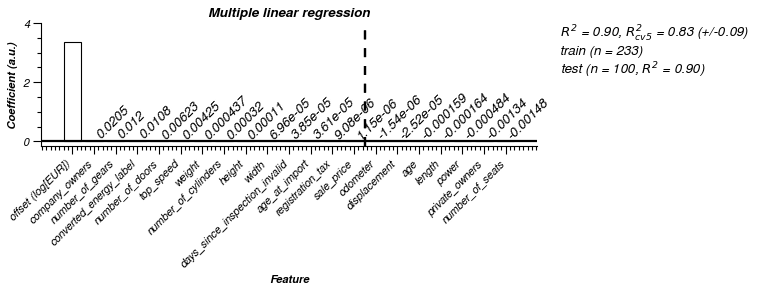

In [19]:
# plot coefficients
plt.figure(figsize=[8,2])

# sorted bar height
betas = models[model_name]['betas']
x = ['offset (log[EUR])'] + [features[i] for i in np.argsort(betas[1:])[::-1]]
y = [betas[0]] + sorted(betas[1:], reverse=True)

# plot bar
plt.bar(x=x, height=y, edgecolor='k', facecolor='None')

# add values when bar is small
for x_val, coef in zip(x,y):
    if np.abs(coef)<1:
        plt.text(x_val, coef, '{:.3g}'.format(coef), rotation=45, va='bottom', ha='left')
plt.yticks(range(0,5,2))

# plot origin
x_sign_switch = np.nonzero(np.array(y) < 0)[0][0]
plt.axvline(x_sign_switch-0.5, linewidth=2, linestyle='--', color='k')
plt.axhline(0, linewidth=2, linestyle='-', color='k')
        
x_sign_switch = np.nonzero(np.array(y) < 0)[0][0]
yl = plt.gca().get_ylim()
plt.vlines(x_sign_switch-0.5, yl[0], yl[1], linewidth=2, linestyle='--')
plt.gca().set_ylim(yl)
# plt.gca().set_ylim(top=0.01, bottom=-0.01)

# labels        
plt.gca().set_xticklabels(labels=x, rotation=45, va='top', ha='right', style='italic')
plt.xlabel('Feature', style='italic')
plt.ylabel('Coefficient (a.u.)', style='italic')
plt.title('Multiple linear regression', style='italic') 

# stats
xy=[plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]]
plt.text(xy[0]*1.05,xy[1], '$R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f})'.format(
    models[model_name]['R^2'],
    models[model_name]['cv R^2'].shape[0],
    np.mean(models[model_name]['cv R^2']),
    np.std(models[model_name]['cv R^2']),
) + '\n' +
         'train (n = {})'.format(y_train.shape[0]) + '\n' +
         'test (n = {}, $R^2$ = {:.2f})'.format(
             y_test.shape[0],
             models[model_name]['test R^2'],
         ), style='italic', va='top', ha='left')


# Save
file_name = '../results/{}.png'.format(model_name.replace(' ','_'))
if (SKIPSAVE==False): #and (not(os.path.isfile(file_name))):
    print(file_name)
    with plt.style.context('../assets/context-paper.mplstyle'):
        plt.savefig(file_name, bbox_inches='tight', transparent=True)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')

<H1><a href="#pred_top">^</a></H1><a id='pred_model_5'> 

- - - - - 
# Model: MLR + imputer

MLR as above, but instead of `dropna` us an imputer. This allows to use more observation.  

At this point a pipeline is used.

## Prepare input

In [20]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model_name = 'MLR impute median'

features = num_columns 
# Can be reduced here

yX = df.loc[:,['price'] + features].dropna(subset=['price'])
X = yX.iloc[:,1:].values.reshape(-1,len(features))
y = np.log10(yX.iloc[:,0].values.reshape(-1,1))
print(X.shape)
print(y.shape)

(5661, 20)
(5661, 1)


## Fit

In [21]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

# create regression model object and store
pl = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    linear_model.LinearRegression()
)
models[model_name].update({'model':pl})

# fit
pl.fit(X,y)
models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})

# parameters
betas = [*pl.steps[-1][1].intercept_, *pl.steps[-1][1].coef_[0]]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':pl.score(X,y)})
models[model_name].update({'test R^2':pl.score(X_test,y_test)})
cv_results = cross_val_score(pl, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})


(3962, 20)
(1699, 20)


../results/MLR_impute_median.png


<ipython-input-22-1f7f51d5134a>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(labels=x, rotation=45, va='top', ha='right', style='italic')


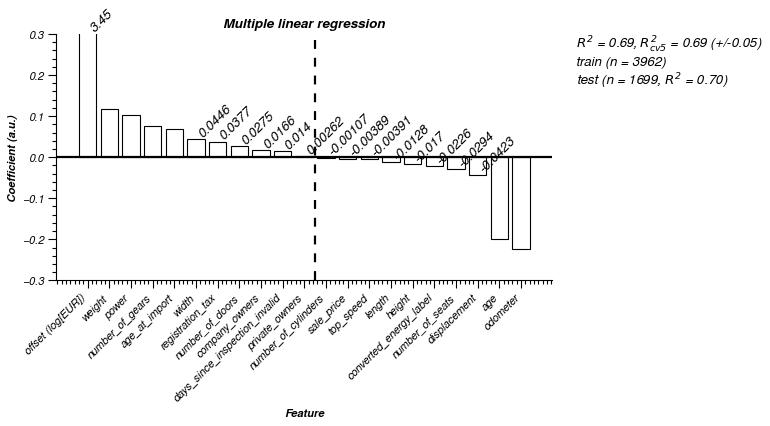

In [22]:
# plot coefficients
plt.figure(figsize=[8,4])

# sorted bar height
betas = models[model_name]['betas']
x = ['offset (log[EUR])'] + [features[i] for i in np.argsort(betas[1:])[::-1]]
y = [betas[0]] + sorted(betas[1:], reverse=True)

# plot bar
plt.bar(x=x, height=y, edgecolor='k', facecolor='None')

# add values when bar is small
for x_val, coef in zip(x,y):
    if np.abs(coef)<0.05:
        plt.text(x_val, coef, '{:.3g}'.format(coef), rotation=45, va='bottom', ha='left')
plt.yticks(np.arange(-0.3,0.4,0.1))
plt.ylim(top=+0.3, bottom=-0.3)
# offset
x_val = x[0]
coef = y[0]
plt.text(x_val, 0.3, '{:.3g}'.format(coef), rotation=45, va='bottom', ha='left')

# plot origin
x_sign_switch = np.nonzero(np.array(y) < 0)[0][0]
plt.axvline(x_sign_switch-0.5, linewidth=2, linestyle='--', color='k')
plt.axhline(0, linewidth=2, linestyle='-', color='k')

# labels        
plt.gca().set_xticklabels(labels=x, rotation=45, va='top', ha='right', style='italic')
plt.xlabel('Feature', style='italic')
plt.ylabel('Coefficient (a.u.)', style='italic')
plt.title('Multiple linear regression', style='italic') 

# stats
xy=[plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]]
plt.text(xy[0]*1.05,xy[1], '$R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f})'.format(
    models[model_name]['R^2'],
    models[model_name]['cv R^2'].shape[0],
    np.mean(models[model_name]['cv R^2']),
    np.std(models[model_name]['cv R^2']),
) + '\n' +
         'train (n = {})'.format(y_train.shape[0]) + '\n' +
         'test (n = {}, $R^2$ = {:.2f})'.format(
             y_test.shape[0],
             models[model_name]['test R^2'],
         ), style='italic', va='top', ha='left')


# Save
file_name = '../results/{}.png'.format(model_name.replace(' ','_'))
if (SKIPSAVE==False): #and (not(os.path.isfile(file_name))):
    print(file_name)
    with plt.style.context('../assets/context-paper.mplstyle'):
        plt.savefig(file_name, bbox_inches='tight', transparent=True)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')

<H1><a href="#pred_top">^</a></H1><a id='pred_model_6'> 

- - - - - 
# Model: MLR with categorical

As MLR, but do one-hot-encoding

Use different scalers for different columns:  
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html  
https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer  
p. 68 book: ML with sklearn & tf

## Prepare input

In [23]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import FeatureUnion

model_name = 'MLR with categorical'

cat_columns_reduced = list(np.setdiff1d(cat_columns, ['model', 'fuel']))
features = num_columns + cat_columns_reduced
# Can be reduced here

# list of lists with categories. Needed for column transformer
cats = list(df[cat_columns_reduced].apply(lambda x:pd.Series(x.unique()).dropna().tolist() + ['missing'], axis='index'))

# Use data frame not array
yX = df.dropna(subset=['price'])
# # only use young
# is_yng = yX.age/365.25 < 25
# yX = yX[is_yng]
X = yX.iloc[:,1:]
y = yX.iloc[:,0]
print(X.shape)
print(y.shape)


(5661, 29)
(5661,)


In [24]:
import re

# Split fuel helper functions

def split_lpg_type(s):
    '''Split lpg type from list of fuels separated by / '''
    # No type
    if s.endswith('lpg'):
        return s, ''
    if 'lpg' not in s:
        return s, ''
    # Type is after the last '/'
    M = re.search('^(.*)/(.*)$',s)
    if M:
        return M[1], M[2]
    else:
        return s, ''

def merge_lpg_and_lpgtype(fuel_type):

    '''Add LPG type to LPG (remove /). 
    Note that order of fuels is preserved. I.e. it is able to return both "benzine/lpg-g3" and "lpg-g3/benzine". '''
    
    lpg_type = fuel_type.apply(lambda s: 'lpg-' + split_lpg_type(s)[1] if (type(s) == str) and ('lpg' in s) else '')
    fuel_type_short = fuel_type.apply(lambda s: split_lpg_type(s)[0] if (type(s) == str) else '')
    fuel_type_new = pd.Series([f.replace('lpg', l) if type(f) == str else f for f,l in zip(fuel_type_short,lpg_type)])
    return fuel_type_new


def get_unique_fuels(fuel_type):
    
    '''Splitting fuels at "/" and return unique values'''
    
    # make list (as string)
    fuel_type_list = fuel_type.apply(lambda s:s.split('/') if type(s) == str else np.NaN).astype(str)
    
    # Get unique fuels
    possible_fuels = list() # empty list
    for l in fuel_type_list.unique():
        for ll in eval(l): # use eval to convert str to list
            possible_fuels += [ll]     
    # uniquify
    return np.unique(possible_fuels)

    
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer to make one-hot fuel encoder based on string
# This is different from get_dummies, because it can take a list of values in a field
class DummyfyFuel(BaseEstimator, TransformerMixin):
    def __init__(self, fuel_names=None):
        
        assert (fuel_names == None) or (isinstance(fuel_names, (list,))), '[fuel_names] should be list (or None)'
        
        self.fuel_names = fuel_names
        
    def fit(self, X, y=None):
        
        if not self.fuel_names:
            # get fuel names based on input.
            # Note that if train/test are split, test might lack a fuel type.
            self.fuel_names = get_unique_fuels(merge_lpg_and_lpgtype(X))

        return self
    
    def transform(self, X):
        
        # get stringyfied list
        fuel_type_list = merge_lpg_and_lpgtype(X).apply(lambda s:s.split('/') if type(s) == str else np.NaN).astype(str)
        # set index as input
        fuel_type_list.index = X.index

        # transform: dummies
        fuel_dummies = pd.DataFrame(index=fuel_type_list.index)
        for f in self.fuel_names:
            fuel_dummies['fuel_' + f] = fuel_type_list.apply(lambda l:int(f in eval(l)))

        return fuel_dummies


In [25]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)


(3962, 29)
(1699, 29)


In [26]:
# Create model

# Preprocessor: numerical features
num_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler(),
)
# Preprocessor: categorical features
cat_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing', missing_values=np.NaN),
    OneHotEncoder(categories=cats),
)

# Preprocess: fuels
# list of all fuels is passed by using full data set! (X)
fuel_list = list(get_unique_fuels(merge_lpg_and_lpgtype(X.fuel)))
#fuel_list = ['benzine', 'diesel']
get_fuel_dummies = DummyfyFuel(fuel_list)


# Combine num and cat
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_transformer, pd.Index(num_columns)),
    ('categorical', cat_transformer, pd.Index(cat_columns_reduced)),
    ('onehot_fuel', get_fuel_dummies, 'fuel')
], verbose=True)

# full pipeline with preproc and mlr
mlr = make_pipeline(
    preprocessor,
    linear_model.LinearRegression()
)

# Target transformation: log transform price
pl = TransformedTargetRegressor(
    regressor=mlr,
    func=np.log10,
    inverse_func=lambda y: 10**y,
#     func=lambda x:x,
#     inverse_func=lambda y: y,
#     inverse_func=np.exp,
)

models[model_name].update({'model':pl})

In [27]:
# fit
pl.fit(X_train, y_train)
y_pred = pl.predict(X_test)

[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.2s


In [28]:
# sanity check that target transformation has occured as expected
# y_pred_manual_transform = mlr.predict(X_test)
# assert all(np.log10(y_pred)-y_pred_manual_transform == 0)

models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})

# parameters
betas = [pl.regressor_.steps[-1][1].intercept_, *pl.regressor_.steps[-1][1].coef_]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':pl.score(X,y)})
models[model_name].update({'test R^2':pl.score(X_test,y_test)})
cv_results = cross_val_score(pl, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})

[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.1s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.1s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.1s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.1s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[Colum

In [29]:
# update features, by adding fuels
cat_columns_reduced += ['fuel']
cats += [fuel_list]


In [30]:
# Split betas per category feature.
idx_start = len(num_columns)+1
cat_betas = list()
for cat in cats:
    cat_betas += [betas[idx_start:idx_start+len(cat)]]
    idx_start += len(cat)
# Check if all betas are stored
assert cat_betas[0][0] == betas[len(num_columns)+1] # first cat beta follows numerical betas 
assert cat_betas[-1][-1] == betas[-1] # last

<ipython-input-31-1eadb93b5dc0>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(labels=x, rotation=rot, va='top', ha=ha, style='italic', fontsize=fsz)
<ipython-input-31-1eadb93b5dc0>:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x, rotation=rot, va='top', ha=ha, style='italic', fontsize=fsz)


../results/MLR_with_categorical.png


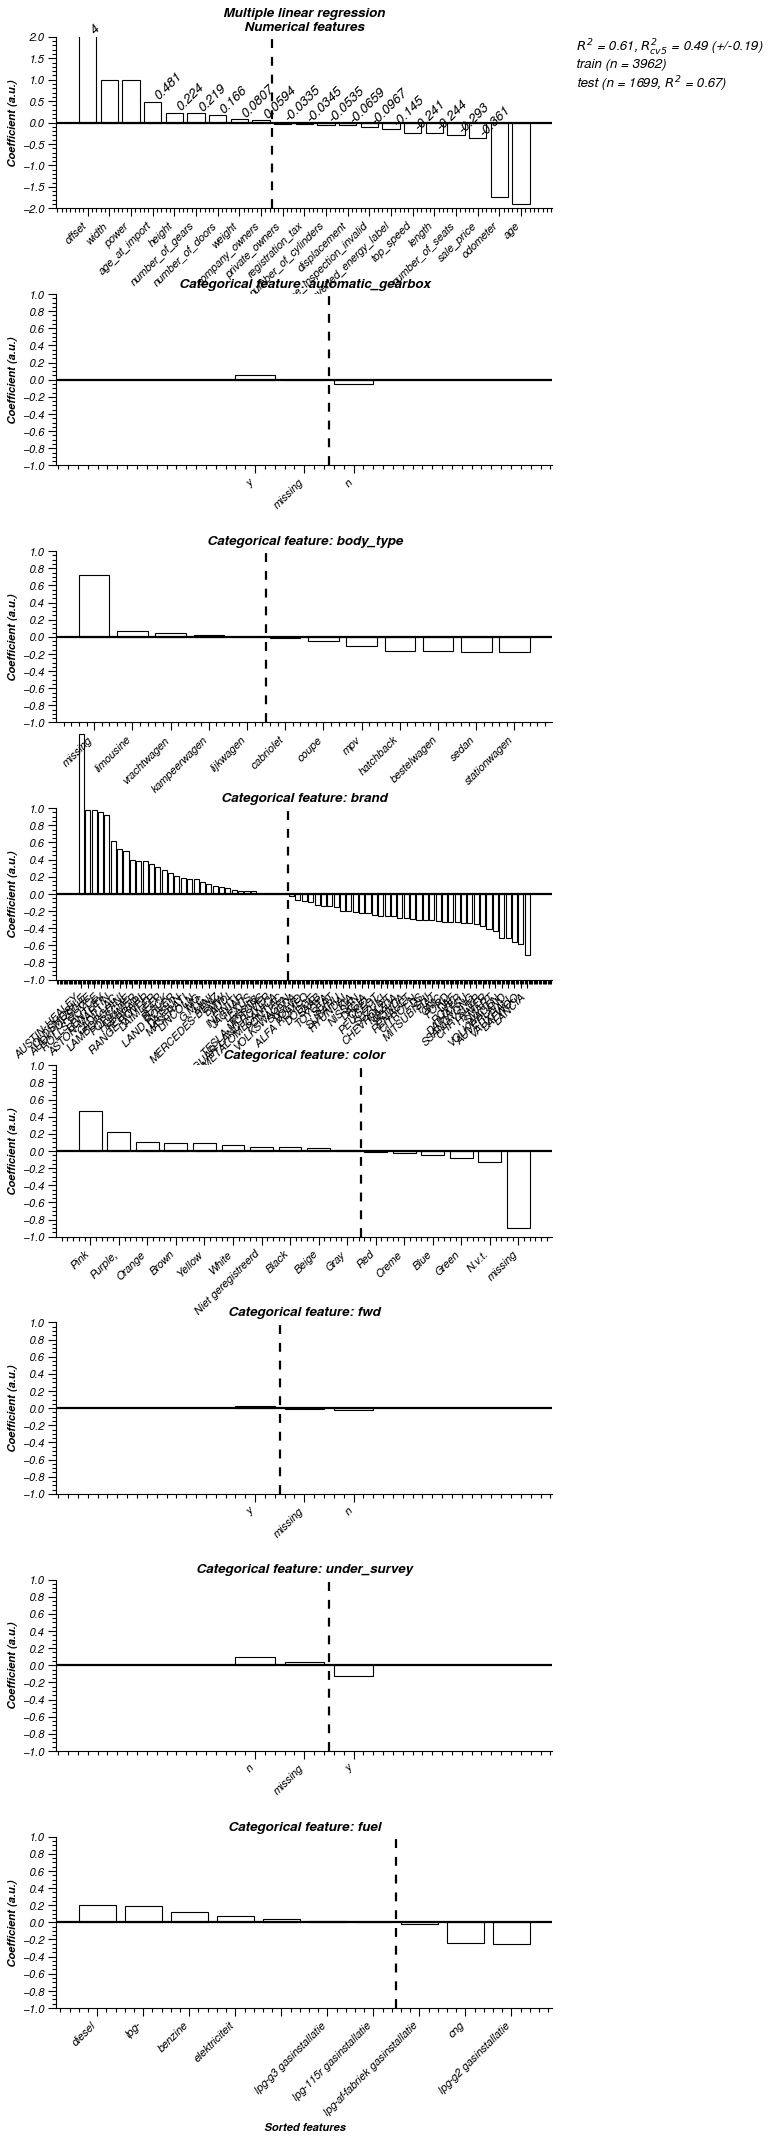

In [31]:
# plot coefficients

# plot numerical and catagorical in different subplots
n_plots = len(cat_columns_reduced) + 1
fig,axs=plt.subplots(
    nrows=n_plots,
    figsize=[8,4*n_plots]
)
plt.subplots_adjust(hspace=0.5)


# Plot numerical
plt.sca(axs[0])
# sorted bar height
betas = models[model_name]['betas']
num_betas = betas[1:len(num_columns)+1]
x = ['offset'] + [features[i] for i in np.argsort(num_betas)[::-1]]
y = [betas[0]] + sorted(num_betas, reverse=True)

# plot bar
plt.bar(x=x, height=y, edgecolor='k', facecolor='None', clip_on=True)

# add values when bar is small
for x_val, coef in zip(x,y):
    if np.abs(coef)<0.5:
        plt.text(x_val, coef, '{:.3g}'.format(coef), rotation=45, va='bottom', ha='left')
plt.yticks(np.arange(-2,2.2,0.5))
plt.ylim(top=+2, bottom=-2)
# offset
x_val = x[0]
coef = y[0]
plt.text(x_val, 2, '{:.3g}'.format(coef), rotation=45, va='bottom', ha='left')

# plot origin
x_sign_switch = np.nonzero(np.array(y) < 0)[0][0]
plt.axvline(x_sign_switch-0.5, linewidth=2, linestyle='--', color='k')
plt.axhline(0, linewidth=2, linestyle='-', color='k')

# labels        
rot = 45
fsz = 10
ha = 'right'
plt.gca().set_xticklabels(labels=x, rotation=rot, va='top', ha=ha, style='italic', fontsize=fsz)
plt.ylabel('Coefficient (a.u.)', style='italic')
plt.title('Multiple linear regression\nNumerical features', style='italic') 

# stats
xy=[plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]]
plt.text(xy[0]*1.05,xy[1], '$R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f})'.format(
    models[model_name]['R^2'],
    models[model_name]['cv R^2'].shape[0],
    np.mean(models[model_name]['cv R^2']),
    np.std(models[model_name]['cv R^2']),
) + '\n' +
         'train (n = {})'.format(y_train.shape[0]) + '\n' +
         'test (n = {}, $R^2$ = {:.2f})'.format(
             y_test.shape[0],
             models[model_name]['test R^2'],
         ), style='italic', va='top', ha='left')

# Plot categorical
for cat, cat_beta, cat_name, ax in zip(cats, cat_betas, cat_columns_reduced, axs[1:]):
    # activate subplot axes
    plt.sca(ax)
    # sort by height
    x = [cat[i] for i in np.argsort(cat_beta)[::-1]]
    y = sorted(cat_beta, reverse=True)
    #x = cat
    #y = cat_beta
    # plot bar
    plt.bar(x=x, height=y, edgecolor='k', facecolor='None', clip_on=False)

    # prettify
    plt.yticks(np.arange(-1,+1.1,0.2))
    plt.ylim(top=+1, bottom=-1)

    # plot origin
    x_sign_switch = np.nonzero(np.array(y) < 0)[0][0]
    plt.axvline(x_sign_switch-0.5, linewidth=2, linestyle='--', color='k')
    plt.axhline(0, linewidth=2, linestyle='-', color='k')

    # labels
    rot = 45
    fsz = 10
    ha = 'right'
    ax.set_xticklabels(labels=x, rotation=rot, va='top', ha=ha, style='italic', fontsize=fsz)
    plt.title('Categorical feature: ' + cat_name, style='italic')
    plt.ylabel('Coefficient (a.u.)', style='italic')
    # add extra margin if bars are too wide (too little bars)
    if len(x) < 10:
        add_space = len(x) - 10
        xl = list(plt.xlim())
        xl[1] -= add_space/2
        xl[0] += add_space/2
        plt.xlim(xl)

# Label on bottom panel
plt.sca(axs[-1])
plt.xlabel('Sorted features', style='italic')

# Save
file_name = '../results/{}.png'.format(model_name.replace(' ','_'))
if (SKIPSAVE==False): #and (not(os.path.isfile(file_name))):
    print(file_name)
    with plt.style.context('../assets/context-paper.mplstyle'):
        plt.savefig(file_name, bbox_inches='tight', transparent=True)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')

<H1><a href="#pred_top">^</a></H1><a id='pred_model_7'> 

- - - - - 
# Model: MLR regularized

As [previous model](#pred_model_6), but use regularization by using built-in Lasso

## Prepare input

In [32]:
from sklearn.model_selection import GridSearchCV

model_name = 'MLR Lasso'

cat_columns_reduced = list(np.setdiff1d(cat_columns, ['model', 'fuel']))
features = num_columns + cat_columns_reduced
# Can be reduced here

# list of lists with categories. Needed for column transformer
cats = list(df[cat_columns_reduced].apply(lambda x:pd.Series(x.unique()).dropna().tolist() + ['missing'], axis='index'))

# Use data frame not array
yX = df.dropna(subset=['price'])
X = yX.iloc[:,1:]
y = yX.iloc[:,0]
print(X.shape)
print(y.shape)


(5661, 29)
(5661,)


## Determine regularization rate (alpha)

Alpha is the hyperparameter that needs to be determined. For this the data needs to be splitted, but the dataset is too small to do a 3 way split (i.e. CV, Train, Test). Therefor spilt 2 way k-fold cv 
- **Test**: Hold-out set for calculating performance
- **Train**: Use to fit model and do CV


In [33]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)


(3962, 29)
(1699, 29)


In [34]:
# Create model (same as MLR with cats, but regressor is Lasso)

# Preprocessor: numerical features
num_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler(),
)
# Preprocessor: categorical features
cat_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing', missing_values=np.NaN),
    OneHotEncoder(categories=cats),
)

# Preprocess: fuels
# list of all fuels is passed by using full data set! (X)
fuel_list = list(get_unique_fuels(merge_lpg_and_lpgtype(X.fuel)))
get_fuel_dummies = DummyfyFuel(fuel_list)


# Combine num and cat
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_transformer, pd.Index(num_columns)),
    ('categorical', cat_transformer, pd.Index(cat_columns_reduced)),
    ('onehot_fuel', get_fuel_dummies, 'fuel')
], verbose=True)

# full pipeline with preproc and mlr
mlr = make_pipeline(
    preprocessor,
    linear_model.Lasso(random_state=42)
)

# Target transformation: log transform price
pl = TransformedTargetRegressor(
    regressor=mlr,
    func=np.log10,
    inverse_func=lambda y: 10**y
)



In [35]:
# grid search estimator
grid_search_alpha = GridSearchCV(
    estimator=pl,
    param_grid=[
        {
            'regressor__lasso__alpha': 10**(np.linspace(-4,-1,13))
        } 
    ],
    cv=8,
    scoring='r2',
    n_jobs=4,
    verbose=10
)

# Perform grid search
grid_search_alpha.fit(X_train,y_train)

Fitting 8 folds for each of 13 candidates, totalling 104 fits
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.2s


GridSearchCV(cv=8,
             estimator=TransformedTargetRegressor(func=<ufunc 'log10'>,
                                                  inverse_func=<function <lambda> at 0x7ff2cfbc3dc0>,
                                                  regressor=Pipeline(steps=[('columntransformer',
                                                                             ColumnTransformer(transformers=[('numerical',
                                                                                                              Pipeline(steps=[('simpleimputer',
                                                                                                                               SimpleImputer(strategy='median')),
                                                                                                                              ('minmaxscaler',
                                                                                                                               MinMaxScal

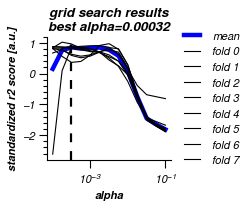

In [36]:
# plot search results
plt.figure(figsize=[2,2])

# abscissa
alphas = list(grid_search_alpha.cv_results_['param_regressor__lasso__alpha'])

# plot mean
r2_mean = grid_search_alpha.cv_results_['mean_test_score']
# normalize
r2_mean = (r2_mean-r2_mean.mean())/r2_mean.std()
plt.plot(alphas, r2_mean, label='mean', lw=4, color='blue')

# plot folds
for fold in range(grid_search_alpha.cv):
    r2_fold = grid_search_alpha.cv_results_['split{:.0f}_test_score'.format(fold)]
    # normalize
    r2_fold = (r2_fold-r2_fold.mean())/r2_fold.std()
    plt.plot(alphas, r2_fold, label='fold ' + str(fold), lw=1, color='black')

plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('standardized r2 score [a.u.]')
plt.axvline(grid_search_alpha.best_params_['regressor__lasso__alpha'], linewidth=2, linestyle='--', color='k')
plt.title('grid search results\nbest alpha={:.5f}'.format(grid_search_alpha.best_params_['regressor__lasso__alpha']))
plt.legend(ncol=1, loc='center left', bbox_to_anchor=(1,0.5))


### Fit with regressor found with grid search

In [37]:
# Store estimator with best alpha
reg = grid_search_alpha.best_estimator_
models[model_name].update({'model':reg})

# fit
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})

# parameters
betas = [reg.regressor_.steps[-1][1].intercept_, *reg.regressor_.steps[-1][1].coef_]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})
models[model_name].update({'test R^2':reg.score(X_test,y_test)})
cv_results = cross_val_score(reg, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})

[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.2s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.1s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.1s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[ColumnTransformer] ... (3 of 3) Processing onehot_fuel, total=   0.1s
[ColumnTransformer] ..... (1 of 3) Processing numerical, total=   0.0s
[ColumnTransformer] ... (2 of 3) Processing categorical, total=   0.0s
[Colum

In [38]:
# update features, by adding fuels
cat_columns_reduced += ['fuel']
cats += [fuel_list]

# Split betas per category feature.
idx_start = len(num_columns)+1
cat_betas = list()
for cat in cats:
    cat_betas += [betas[idx_start:idx_start+len(cat)]]
    idx_start += len(cat)
# Check if all betas are stored
assert cat_betas[0][0] == betas[len(num_columns)+1] # first
assert cat_betas[-1][-1] == betas[-1] # last

<ipython-input-39-520b4d87d7d8>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x, rotation=rot, va='top', ha=ha, style='italic', fontsize=fsz)


../results/MLR_Lasso.png


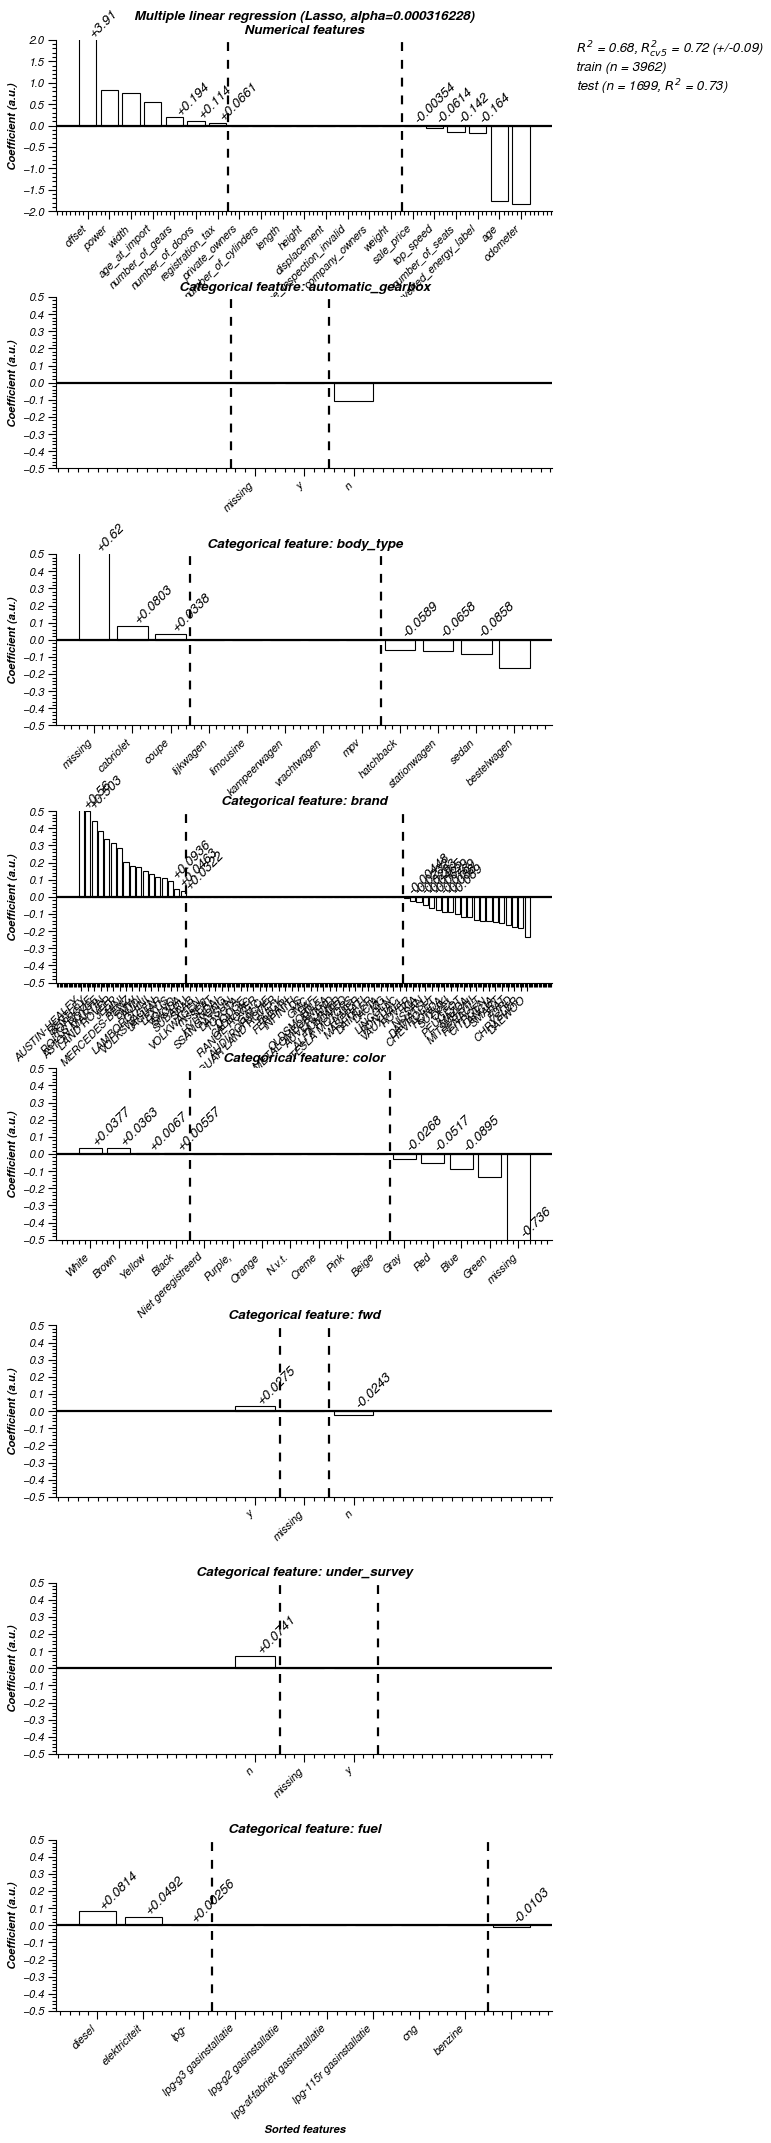

In [39]:
# plot coefficients

# plot numerical and catagorical in different subplots
n_plots = len(cat_columns_reduced) + 1
fig,axs=plt.subplots(
    nrows=n_plots,
    figsize=[8,4*n_plots]
)
plt.subplots_adjust(hspace=0.5)

# Plot coefficients
for feats, coefs, name, ax in zip(
    [['offset'] + features] + cats,
    [[betas[0]] + betas[1:len(num_columns)+1]] + cat_betas,
    ['numerical'] + cat_columns_reduced,
    axs
):
    # activate subplot axes
    plt.sca(ax)
    # sort by bar height
    x = [feats[i] for i in np.argsort(coefs)[::-1]]
    y = sorted(coefs, reverse=True)
    # plot bar
    plt.bar(x=x, height=y, edgecolor='k', facecolor='None', clip_on=True)

    # prettify
    if not name.startswith('num'):
        plt.yticks(np.arange(-0.5,+0.6,0.1))
        bot_tick, top_tick = plt.ylim(top=+0.5, bottom=-0.5)
    else:
        plt.yticks(np.arange(-2,2.2,0.5))
        bot_tick, top_tick = plt.ylim(top=+2, bottom=-2)
        # stats
        xy=[plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]]
        plt.text(xy[0]*1.05,xy[1], '$R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f})'.format(
            models[model_name]['R^2'],
            models[model_name]['cv R^2'].shape[0],
            np.mean(models[model_name]['cv R^2']),
            np.std(models[model_name]['cv R^2']),
        ) + '\n' +
                 'train (n = {})'.format(y_train.shape[0]) + '\n' +
                 'test (n = {}, $R^2$ = {:.2f})'.format(
                     y_test.shape[0],
                     models[model_name]['test R^2'],
                 ), style='italic', va='top', ha='left')


    # plot sign switch
    x_sign_switch1 = np.nonzero(np.array(y+[-np.inf]) < 0)[0][0]
    x_sign_switch2 = np.nonzero(np.array([+np.inf]+y) > 0)[0][-1]
    plt.axvline(x_sign_switch1-0.5, linewidth=2, linestyle='--', color='k')
    plt.axvline(x_sign_switch2-0.5, linewidth=2, linestyle='--', color='k')
    plt.axhline(0, linewidth=2, linestyle='-', color='k')

    # add values when bar is small or too large (clipping)
    yt,ytl=plt.yticks()
    first_tick = sorted(np.abs(yt))[1]
    for x_val, coef in zip(x,y):
        if (coef < first_tick) & (coef > 0):
            plt.text(x_val, coef, '{:+.3g}'.format(coef), rotation=45, va='bottom', ha='left')
        elif (coef > -first_tick) & (coef < 0):
            plt.text(x_val, 0, '{:+.3g}'.format(coef), rotation=45, va='bottom', ha='left')
        elif coef > top_tick:
            # generally this is offset (bias)
            plt.text(x_val, top_tick, '{:+.3g}'.format(coef), rotation=45, va='bottom', ha='left')
        elif coef < bot_tick:
            plt.text(x_val, bot_tick, '{:+.3g}'.format(coef), rotation=45, va='bottom', ha='left')

    
    # labels and titles
    rot = 45
    fsz = 10
    ha = 'right'
    ax.set_xticklabels(labels=x, rotation=rot, va='top', ha=ha, style='italic', fontsize=fsz)
    if not name.startswith('num'):
        plt.title('Categorical feature: ' + name, style='italic')
    else:
        plt.title('Multiple linear regression (Lasso, alpha={:g})\nNumerical features'.format(
            reg.regressor_.named_steps['lasso'].alpha
        ), style='italic') 
    plt.ylabel('Coefficient (a.u.)', style='italic')
    
    # add extra margin if bars are too wide (too little bars)
    if len(x) < 10:
        add_space = len(x) - 10
        xl = list(plt.xlim())
        xl[1] -= add_space/2
        xl[0] += add_space/2
        plt.xlim(xl)

# Label on bottom panel
plt.sca(axs[-1])
plt.xlabel('Sorted features', style='italic')

# Save
file_name = '../results/{}.png'.format(model_name.replace(' ','_'))
if (SKIPSAVE==False): #and (not(os.path.isfile(file_name))):
    print(file_name)
    with plt.style.context('../assets/context-paper.mplstyle'):
        plt.savefig(file_name, bbox_inches='tight', transparent=True)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')

- - - - - 

best predictons


,2021-05-8136,2019-2-2001,2021-04-7128,2021-03-8058,2020-8-7113,2021-04-2212,2017-3-2212,2019-12-2204,2021-04-7160,2019-10-7139,2018-6-2414,2020-2-8105,2017-10-7115,2019-4-7132,2018-5-8113,2018-6-7191
brand,CITROËN,PEUGEOT,CHEVROLET,VOLKSWAGEN,DODGE,BMW,BMW,VOLKSWAGEN,BMW,RENAULT,MERCEDES-BENZ,VOLKSWAGEN,MERCEDES-BENZ,RENAULT,VOLKSWAGEN,VOLKSWAGEN
model,c3,308,orlando,polo,caliber,330d,114i,polo,3er reihe,clio,cla 45 amg 4matic,polo,c 320,megane,polo,passat
age,3685.0,1575.0,3332.0,3798.0,5008.0,2904.0,1294.0,3573.0,6322.0,6293.0,1547.0,6151.0,5939.0,2334.0,3121.0,4508.0
fuel,diesel,diesel,diesel,diesel,benzine/lpg/g3 gasinstallatie,diesel,benzine,diesel,benzine,benzine,benzine,benzine,benzine,diesel,diesel,diesel
odometer,240219.0,169183.0,174840.0,248276.0,239875.0,145596.0,48796.0,157715.0,174749.0,NaN,26796.0,189281.0,203325.0,192965.0,207149.0,275283.0
days_since_inspection_invalid,32.0,80.0,148.0,52.0,65.0,-143.0,-167.0,651.0,-83.0,-180.0,-645.0,-156.0,NaN,NaN,NaN,NaN
age_at_import,0.0,0.0,1623.0,1775.0,0.0,0.0,740.0,209.0,1269.0,0.0,558.0,1977.0,0.0,NaN,NaN,0.0
body_type,hatchback,mpv,stationwagen,hatchback,hatchback,cabriolet,stationwagen,hatchback,sedan,hatchback,sedan,hatchback,sedan,NaN,NaN,stationwagen
displacement,1560.0,1560.0,1998.0,1199.0,1998.0,2993.0,1598.0,1598.0,1995.0,1149.0,1991.0,1390.0,3199.0,NaN,NaN,1968.0
number_of_cylinders,4.0,4.0,4.0,3.0,4.0,6.0,4.0,4.0,4.0,4.0,4.0,4.0,6.0,NaN,NaN,4.0


worst predictions


,2017-3-8109,2020-9-3035,2019-2-7260,2019-9-2211,2018-7-2415,2019-4-2021,2019-8-2221,2017-3-2003,2017-3-2007,2017-3-2409,2017-5-2216,2021-03-2606,2017-3-2000,2018-1-2412,2018-7-2411,2021-05-2201
brand,MERCEDES-BENZ,PEUGEOT,OPEL,BMW,AUSTIN-HEALEY,VOLKSWAGEN,ALFA ROMEO,VOLKSWAGEN,VOLKSWAGEN,VOLKSWAGEN,ALFA ROMEO,JAGUAR,ALFA ROMEO,VOLKSWAGEN,MERCEDES-BENZ,MERCEDES-BENZ
model,e 200 cdi,306,ascona 1.6s,323 i,3000 mkiii phase ii,111011,giulia 1300 super,152131,karmann ghia,T2,2000 gtv,e-type,2000 gtv,t1,sl230,w100 600 pullman
age,4291.0,7549.0,11956.0,13719.0,19116.0,19787.0,17379.0,15121.0,18507.0,15873.0,16257.0,18507.0,16196.0,19813.0,19848.0,20451.0
fuel,diesel,diesel,benzine,benzine,benzine,benzine,benzine,benzine,benzine,benzine,benzine,benzine,benzine,benzine,benzine,benzine
odometer,816757.0,NaN,3314.0,175825.0,106800.895872,91157.0,9050.0,84145.0,59227.0,46642.0,23982.0,20623.0,23982.0,96563.858688,68722.0,NaN
days_since_inspection_invalid,-409.0,NaN,66.0,NaN,-402.0,1099.0,NaN,NaN,NaN,NaN,-739.0,NaN,-800.0,NaN,NaN,NaN
age_at_import,0.0,NaN,0.0,NaN,18063.0,16180.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN
body_type,sedan,NaN,NaN,NaN,cabriolet,sedan,NaN,NaN,NaN,NaN,coupe,NaN,coupe,NaN,NaN,NaN
displacement,2148.0,NaN,NaN,NaN,2912.0,1192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_of_cylinders,4.0,NaN,4.0,NaN,6.0,4.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN


largest underestimate


,2018-8-2400,2019-4-2411,2019-11-2418,2018-6-2410,2018-8-2410,2021-05-8126,2017-3-2000,2018-7-2411,2019-8-2415,2017-8-2409,2018-6-2408,2017-5-2406,2021-05-2401,2020-1-2409,2017-9-2408,2020-11-2407
brand,ROLLS ROYCE,MERCEDES-BENZ,PORSCHE,MERCEDES-BENZ,ASTON-MARTIN,MERCEDES-BENZ,ALFA ROMEO,MERCEDES-BENZ,LAMBORGHINI,PORSCHE,AUDI,MERCEDES-BENZ,PORSCHE,FERRARI,MERCEDES-BENZ,FERRARI
model,phantom drophead coupe,amg s63 cabriolet,panamera turbo s e-hybrid,S65 AMG,dbs,v-klasse,2000 gtv,sl230,gallardo,911 carrera s,rs6 avant,S600 Maybach,911 gt3,california,c-klasse 63 s AMG *,360 modena spider
age,3136.0,636.0,431.0,844.0,2665.0,1506.0,16196.0,19848.0,4960.0,2039.0,1663.0,810.0,7744.0,3103.0,813.0,6793.0
fuel,benzine,benzine,NaN,benzine,benzine,diesel,benzine,benzine,benzine,NaN,benzine,benzine,benzine,benzine,benzine,benzine
odometer,11305.0,13.0,6925.0,6379.0,58429.0,121324.0,23982.0,68722.0,26380.0,59807.0,37397.0,19173.0,38157.0,67710.0,15636.0,35614.0
days_since_inspection_invalid,NaN,NaN,NaN,NaN,NaN,-320.0,-800.0,NaN,NaN,NaN,NaN,-651.0,2314.0,166.0,NaN,134.0
age_at_import,NaN,NaN,NaN,NaN,NaN,1067.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,264.0,NaN,5559.0
body_type,NaN,NaN,NaN,NaN,NaN,mpv,coupe,NaN,NaN,NaN,NaN,sedan,coupe,cabriolet,NaN,cabriolet
displacement,NaN,NaN,NaN,NaN,NaN,2143.0,NaN,NaN,NaN,NaN,NaN,5980.0,3600.0,4297.0,NaN,3586.0
number_of_cylinders,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,12.0,6.0,8.0,NaN,8.0


largest overestimate


,2018-5-2402,2018-1-2411,2020-6-2221,2020-12-2210,2020-9-2405,2019-6-2403,2019-12-2407,2021-03-2206,2019-9-2400,2021-04-2205,2017-3-2400,2020-1-2414,2019-9-2401,2017-3-2405,2018-11-2401,2021-03-2610
brand,BMW,BMW,LAND ROVER,LAND ROVER,LAND ROVER,MERCEDES-BENZ,MERCEDES-BENZ,VOLVO,MERCEDES-BENZ,MERCEDES-BENZ,ASTON-MARTIN,MERCEDES-BENZ,MERCEDES-BENZ,MERCEDES-BENZ,BENTLEY,LAND ROVER
model,x6 xdrive40d,x5 m50d,discovery sport,range rover,range rover evoque,amg c 63 s,amg c63 s,xc90 t8 twin engine,amg glc 63 s 4matic,gle 350 d 4matic,rapide s,amg gle 63 s,amg g 63,amg gle 63 s,continental gtc,range rover sport
age,573.0,1761.0,1581.0,2043.0,889.0,904.0,1059.0,579.0,216.0,1718.0,673.0,1063.0,144.0,484.0,4200.0,1851.0
fuel,diesel,diesel,diesel,diesel,benzine,benzine,benzine,elektriciteit/benzine,benzine,diesel,benzine,benzine,benzine,benzine,benzine,benzine
odometer,13744.0,36340.0,62423.0,73260.0,25563.0,30129.0,22356.0,7071.0,7702.0,55224.0,14415.0,31404.0,969.0,20757.0,27184.0,110979.0
days_since_inspection_invalid,-522.0,-102.0,485.0,154.0,-572.0,-557.0,-402.0,-882.0,-1245.0,244.0,-788.0,-398.0,-1317.0,-977.0,-21.0,-121.0
age_at_import,0.0,1349.0,910.0,1602.0,297.0,544.0,329.0,0.0,0.0,1067.0,297.0,526.0,0.0,135.0,2028.0,1246.0
body_type,sedan,stationwagen,stationwagen,stationwagen,stationwagen,coupe,cabriolet,mpv,stationwagen,stationwagen,hatchback,stationwagen,stationwagen,stationwagen,cabriolet,stationwagen
displacement,2993.0,2993.0,1999.0,4367.0,1997.0,3982.0,3982.0,1969.0,3982.0,2987.0,5935.0,5461.0,3982.0,5461.0,5998.0,4999.0
number_of_cylinders,6.0,6.0,4.0,8.0,4.0,8.0,8.0,4.0,8.0,6.0,12.0,8.0,8.0,8.0,12.0,8.0


Text(0, 0.5, 'prediction error [log of fraction]\n(positive: prediction overestimates)')

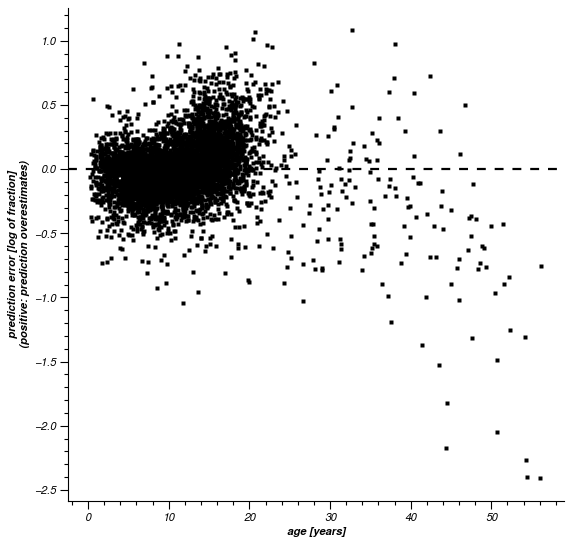

In [40]:
# Display prediction errors

x_sample = df.dropna(subset=['price']).iloc[:,1:]
y_sample = df.dropna(subset=['price']).iloc[:,0]
y_sample_pred = models[model_name]['model'].predict(x_sample) 

x_sample['price'] = y_sample
x_sample['prediction_error'] = y_sample_pred - y_sample
x_sample['prediction_error_fraction'] = y_sample_pred/y_sample
x_sample['prediction_error_log'] = np.log10(x_sample.prediction_error_fraction)
x_sample['prediction_error_abslog'] = np.abs(np.log10(x_sample.prediction_error_fraction))
x_sample['prediction'] = y_sample_pred
x_sample['age_y'] = x_sample.age/365

# Note some are close to perfect, because they are in training set and are unique in brand etc
print('best predictons')
display(x_sample.sort_values(by='prediction_error_abslog').head(16).T)
print('worst predictions')
display(x_sample.sort_values(by='prediction_error_abslog').tail(16).T)
print('largest underestimate')
display(x_sample.sort_values(by='prediction_error').head(16).T)
print('largest overestimate')
display(x_sample.sort_values(by='prediction_error').tail(16).T)

plt.figure(figsize=[8,8])
plt.plot(x_sample.age_y, x_sample.prediction_error_log, color='k', marker='s', markeredgecolor = (0, 0, 0, 0), markerfacecolor = (0, 0, 0, 1), linestyle='None', ms=4)
plt.axhline(0, lw=2, linestyle='--', color ='k')
plt.xlabel('age [years]')
plt.ylabel('prediction error [log of fraction]\n(positive: prediction overestimates)')

In [41]:
# check to see if combining features would improve model
yX = df.dropna(subset=['price'])
yX.loc[:,'usage_intensity'] = (yX.odometer / yX.age)
yX.loc[:,'classic'] = yX.age > 25
print(yX.corr().price)
print('\n"usage_intensity" does not seem to correlate better than "age" and "odometer" seperately')

price                            1.000000
age                             -0.358189
odometer                        -0.447953
days_since_inspection_invalid   -0.148711
age_at_import                    0.034634
displacement                     0.382675
number_of_cylinders              0.362321
power                            0.608187
weight                           0.400951
registration_tax                 0.381242
sale_price                       0.718219
number_of_seats                 -0.025525
number_of_doors                  0.170214
top_speed                        0.494901
length                           0.289689
height                           0.067838
width                            0.422380
number_of_gears                  0.599516
private_owners                  -0.313588
company_owners                   0.115308
converted_energy_label           0.257191
usage_intensity                 -0.055195
classic                          0.020549
Name: price, dtype: float64

"usag

/home/tom/bin/py38-satdatsci/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/tom/bin/py38-satdatsci/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/tom/bin/py38-satdatsci/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

<H1><a href="#pred_top">^</a></H1><a id='pred_model_8'> 

<H1><a href="#pred_top">^</a></H1><a id='pred_accuracies'> 

## Model accuracies

../results/model-performance.png


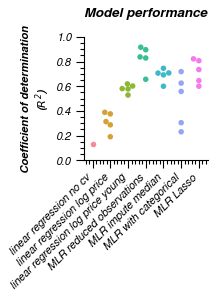

In [42]:
# plot R^2

# counter for x-offset
c=0

# figure
fig = plt.figure(figsize=[2,2])
ax = fig.gca()
xs = ys = [None]

# loop over all models
for name,res in models.items():

    c+=1 # x-offset

    if name == 'linear regression no cv':
        # No cv, so only one value. Make it a list of one for type consistency
        k = 'R^2'
        rsq = [res[k]]
    
    else: 
        k = 'cv R^2'
        rsq = res[k]
        
    # add r-squares and offset to vectors
    ys = np.concatenate([ys,rsq])
    xs = np.concatenate([xs,np.ones_like(rsq) * c])

# actual plotting
sns.swarmplot(x=xs, y=ys, ax=ax)
# prettify
ax.set_xticklabels(models.keys(), rotation=45, va='top', ha='right', style='italic')
ax.set_ylim(bottom=0, top=1)
ax.set_title('Model performance\n', style='italic')
ax.set_ylabel('Coefficient of determination\n($R^2$)', style='italic')


# save
file_name = '../results/model-performance.png'
if (SKIPSAVE==False): #and (not(os.path.isfile(file_name))):
    print(file_name)
    with plt.style.context('../assets/context-paper.mplstyle'):
        plt.savefig(file_name, bbox_inches='tight', transparent=True)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')

linear regression no cv
9379.123534962424
../results/linear_regression_no_cv-accuracy.png
linear regression log price
9575.755476280661
../results/linear_regression_log_price-accuracy.png
linear regression log price young
8573.921641958997
../results/linear_regression_log_price_young-accuracy.png
MLR reduced observations
5575.2309161236835
../results/MLR_reduced_observations-accuracy.png
MLR impute median
8807.722070179321
../results/MLR_impute_median-accuracy.png
MLR with categorical
6263.116679054209
../results/MLR_with_categorical-accuracy.png
MLR Lasso
5717.20201702177
../results/MLR_Lasso-accuracy.png


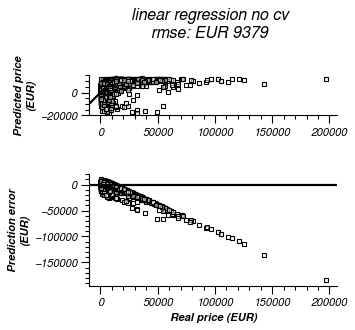

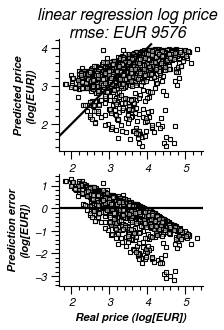

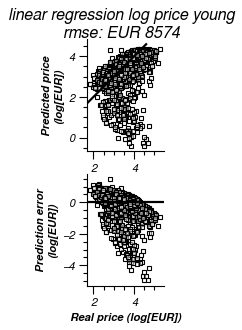

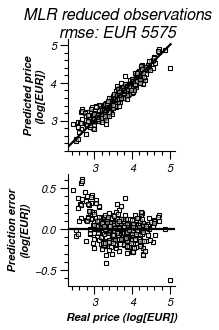

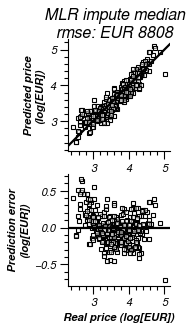

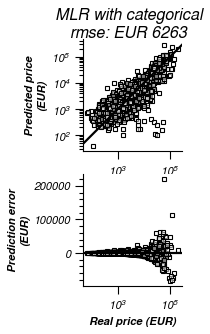

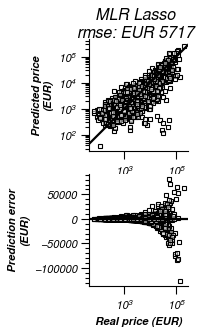

In [43]:
# plot data

# loop over all models
for model_name in models.keys():
    print(model_name)
    res = models[model_name]
    
    # all original data
    yX = df.loc[:,['price', 'age']].dropna()
    X = yX.iloc[:,1]
    y = yX.iloc[:,0]
    
    features = num_columns.copy()
    
    # model specific adjustments
    if (model_name == 'linear regression log price') or (model_name == 'linear regression log price young'):
        # log price is used
        y = np.log10(y)
        # unit
        unit = '(log[EUR])'
    elif (model_name == 'MLR reduced observations') or (model_name == 'MLR impute median'):
        yX = df.dropna(subset=['price'] + features).loc[:,['price'] + features]
        X = yX.iloc[:,1:]
        y = np.log10(yX.iloc[:,0])
        unit = '(log[EUR])'
    elif (model_name == 'MLR with categorical') or (model_name == 'MLR Lasso') or (model_name == 'MLR added features'):
        yX = df.dropna(subset=['price']).copy()
        X = yX.iloc[:,1:]
        y = yX.iloc[:,0]      
        unit = '(EUR)'
    else:
        unit = '(EUR)'
    
    if X.ndim != 1:
        n_feat = X.shape[1]
    else:
        n_feat = 1
        
    if not ((model_name == 'MLR with categorical') or (model_name == 'MLR Lasso') or (model_name == 'MLR added features')):
        # needed for .predict
        X = np.array(X).reshape(-1,n_feat)
        y = np.array(y).reshape(-1,1)
    
    # predict all data
    y_pred = res['model'].predict(X)
    if max(y) < 10:
        rmse = np.sqrt(np.mean(((10**y)-(10**y_pred))**2))
    else:
        rmse = np.sqrt(np.mean((y-y_pred)**2))
    print(rmse)

    # actual plotting
    fig,axs = plt.subplots(nrows=2, ncols=1, figsize=[4,4])
    
    # data
    axs[0].plot(y, y_pred, marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4,)
    # error
    axs[1].plot(y, y_pred-y, marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4,)
    
    # axis equal for top
    if (model_name == 'MLR with categorical') or (model_name == 'MLR Lasso') or (model_name == 'MLR added features'):
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')
        axs[1].set_xscale('log')
    axs[0].set_aspect(1)
    # store limits
    yl = axs[0].get_ylim()
    xl_top = axs[0].get_xlim()
    xl_bot = axs[1].get_xlim()
    xl = [np.max([xl_top[0], xl_bot[0]]), np.min([xl_top[1], xl_bot[1]])]
    # plot unity line and 0 error
    unity_line = [np.max([xl[0], yl[0]]), np.min([xl[1], yl[1]])]
    axs[0].plot(unity_line, unity_line, '-k', linewidth=2)
    axs[1].plot(xl, [0, 0], '-k', linewidth=2)
    # reset limits
    axs[0].set_xlim(xl)
    axs[1].set_xlim(xl)

    # make equal size panels
    # Note: sharex did not work
    bb=axs[0].get_position(False)
    rect_top = bb.bounds
    bb=axs[1].get_position(False)
    rect_bot = bb.bounds
    rect = list(rect_bot)
    rect[0] = rect_top[0]
    rect[2] = rect_top[2]
    axs[1].set_position(rect)
    
    # labeling
    fig.suptitle('{}\nrmse: EUR {:.0f}'.format(model_name,rmse), style='italic')
    axs[1].set_xlabel('Real price ' + unit, style='italic')
    axs[0].set_ylabel('Predicted price\n' + unit, style='italic')
    axs[1].set_ylabel('Prediction error\n' + unit, style='italic')
    
    # save
    file_name = '../results/{}-accuracy.png'.format(model_name.replace(' ','_'))
    if (SKIPSAVE==False): #and (not(os.path.isfile(file_name))):
        print(file_name)
        with plt.style.context('../assets/context-paper.mplstyle'):
            plt.savefig(file_name, bbox_inches='tight', transparent=True)
    else:
        plt.show()
        print(f'Skip. {file_name} exists or saving is disabled in settings.')

<H1><a href="#pred_top">^</a></H1><a id='pred_save_model'> 

# Save model as pickle
Save the best model as a .pkl file.

See also: https://scikit-learn.org/stable/modules/model_persistence.html

In [44]:
# import dill # dill acts as pickle but handles lambda functions
model_name = 'MLR Lasso' 
model = models[model_name]

In [45]:
model['name'] = model_name
fn = '../results/trained_model_{}.pkl'.format(model_name.replace(' ', '_').lower())
print(fn)
# with open(fn, 'wb') as file:
#     dill.dump(model, file)

../results/trained_model_mlr_lasso.pkl


<H1><a href="#pred_top">^</a></H1><a id='pred_predict'> 

# Example predictions

In [46]:
# Predict some known cars
B = pd.DataFrame(columns=X.columns, index=['Mine'])
B.loc['Mine', ['brand', 'model', 'fuel', 'body_type', 'color']] = ['CITROËN', 'berlingo', 'benzine', 'mpv', 'Gray']
B.loc['Mine', ['displacement', 'number_of_cylinders', 'number_of_seats', 'number_of_doors', 'fwd', 'number_of_gears']] = [1600, 4, 5, 5, 'n', 5]
B.loc['Mine', ['top_speed']] = [170]
B.loc['Mine', 'age'] = (pd.to_datetime('now') - pd.to_datetime('2005-12-1')).days
B.loc['Mine', 'days_since_inspection_invalid'] = (pd.to_datetime('now') - pd.to_datetime('2021-6-11')).days
B.loc['Mine', 'age_at_import'] = 0
B.loc['Mine', 'odometer'] = 160000
B.loc['Mine', ['weight']] = [1326]

B.loc['Peer', ['brand', 'model', 'fuel', 'body_type', 'color']] = ['CITROËN', 'ax', 'benzine', 'hatchback', 'Gray']
B.loc['Peer', ['displacement', 'number_of_cylinders', 'number_of_seats', 'number_of_doors', 'fwd', 'number_of_gears']] = [1100, 4, 5, 5, 'n', 5]
B.loc['Peer', ['top_speed']] = [170]
B.loc['Peer', 'age'] = (pd.to_datetime('now') - pd.to_datetime('1996-12-1')).days
# B.loc['Mine', 'days_since_inspection_invalid'] = (pd.to_datetime('now') - pd.to_datetime('2020-6-11')).days
B.loc['Peer', 'age_at_import'] = 0
B.loc['Peer', 'odometer'] = 160000
B.loc['Peer', ['weight']] = [800]

B.loc['golf+', ['brand', 'model', 'fuel', 'body_type', 'color']] = ['VOLKSWAGEN', 'golf plus', 'benzine', 'mpv', 'Blue']
B.loc['golf+', ['displacement', 'number_of_cylinders', 'number_of_seats', 'number_of_doors', 'fwd', 'number_of_gears']] = [1598, 4, 5, 5, 'n', 6]
B.loc['golf+', 'age'] = (pd.to_datetime('now') - pd.to_datetime('2006-10-02')).days
B.loc['golf+', 'age_at_import'] = 0
B.loc['golf+', 'days_since_inspection_invalid'] = (pd.to_datetime('now') - pd.to_datetime('2019-8-8')).days
B.loc['golf+', 'odometer'] = 154657
B.loc['golf+', ['weight']] = [1431]

B.loc['45-TRN-4', ['brand', 'model', 'fuel', 'body_type', 'color']] = ['VOLKSWAGEN', 'golf', 'benzine', 'hatchback', 'Gray']
B.loc['45-TRN-4', ['displacement', 'number_of_cylinders', 'number_of_seats', 'number_of_doors', 'fwd', 'number_of_gears']] = [1197, 4, 5, 5, 'n', 6]
B.loc['45-TRN-4', 'age'] = (pd.to_datetime('now') - pd.to_datetime('2012-3-29')).days
B.loc['45-TRN-4', 'age_at_import'] = 0
B.loc['45-TRN-4', 'days_since_inspection_invalid'] = (pd.to_datetime('now') - pd.to_datetime('2020-3-29')).days
B.loc['45-TRN-4', 'odometer'] = 221941
B.loc['45-TRN-4', ['weight']] = [1271]

B.loc['5-KVJ-78', ['brand', 'model', 'fuel', 'body_type', 'color']] = ['VOLKSWAGEN', 'golf', 'benzine', 'hatchback', 'Gray']
B.loc['5-KVJ-78', ['displacement', 'number_of_cylinders', 'number_of_seats', 'number_of_doors', 'fwd', 'number_of_gears']] = [1197, 4, 5, 5, 'n', 6]
B.loc['5-KVJ-78', 'age'] = (pd.to_datetime('now') - pd.to_datetime('2013-7-31')).days
B.loc['5-KVJ-78', 'age_at_import'] = 0
B.loc['5-KVJ-78', 'days_since_inspection_invalid'] = (pd.to_datetime('now') - pd.to_datetime('2019-7-31')).days
B.loc['5-KVJ-78', 'odometer'] = 180885
B.loc['5-KVJ-78', ['weight']] = [1251]

B.loc['a car', ['brand']] = [np.NaN]

B.loc['86-PH-GS', ['brand', 'model', 'fuel', 'body_type', 'color']] = ['MAZDA', '3', 'benzine', 'sedan', 'Gray']
B.loc['86-PH-GS', ['displacement', 'number_of_cylinders', 'number_of_seats', 'number_of_doors', 'fwd']] = [1598, 4, 5, 5, 'n']
B.loc['86-PH-GS', 'age_at_import'] = 0
B.loc['86-PH-GS', 'age'] = (pd.to_datetime('now') - pd.to_datetime('25-06-2004')).days
B.loc['86-PH-GS', 'days_since_inspection_invalid'] = (pd.to_datetime('now') - pd.to_datetime('18-01-2020')).days
B.loc['86-PH-GS', 'weight'] = 1165
B.loc['86-PH-GS', 'odometer'] = 103174
B.loc['86-PH-GS', 'automatic_gearbox'] = 'y'


In [47]:
B.T

,Mine,Peer,golf+,45-TRN-4,5-KVJ-78,a car,86-PH-GS
brand,CITROËN,CITROËN,VOLKSWAGEN,VOLKSWAGEN,VOLKSWAGEN,NaN,MAZDA
model,berlingo,ax,golf plus,golf,golf,NaN,3
age,5636,8923,5331,3326,2837,NaN,6160
fuel,benzine,benzine,benzine,benzine,benzine,NaN,benzine
odometer,160000,160000,154657,221941,180885,NaN,103174
days_since_inspection_invalid,-35,NaN,638,404,646,NaN,475
age_at_import,0,0,0,0,0,NaN,0
body_type,mpv,hatchback,mpv,hatchback,hatchback,NaN,sedan
displacement,1600,1100,1598,1197,1197,NaN,1598
number_of_cylinders,4,4,4,4,4,NaN,4


In [48]:
df_ = pd.DataFrame(index=models, columns=B.index)
for model in models:
    try:
        B.loc[:,'predict'] = models[model]['model'].predict(B)
        pred = B.predict
    except: 
        pred = pd.Series(index=B.index, data=np.NaN)
    df_.loc[model,:] = pred
    
df_

,Mine,Peer,golf+,45-TRN-4,5-KVJ-78,a car,86-PH-GS
linear regression no cv,NaN,NaN,NaN,NaN,NaN,NaN,NaN
linear regression log price,NaN,NaN,NaN,NaN,NaN,NaN,NaN
linear regression log price young,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MLR reduced observations,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MLR impute median,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MLR with categorical,1511.252234,631.460563,2805.509424,3211.62092,4351.020981,2304.008584,1659.218747
MLR Lasso,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
B = pd.read_pickle('/home/tom/bin/satdatsci/Saturday-Datascience/data/rdw-data-2021-02.pkl')
B.columns
#['brand', 'model', 'fuel', 'body_type', 'color']
B.loc[:, [
    'rdw_merk',
    'rdw_type',
    'rdw_brandstof_brandstof_omschrijving_1',
    'rdw_ovi_inrichting_code_omschrijving',
    'rdw_eerste_kleur',
     ]]

,rdw_merk,rdw_type,rdw_brandstof_brandstof_omschrijving_1,rdw_ovi_inrichting_code_omschrijving,rdw_eerste_kleur
2021-02-1800,SYM,XC05W,Benzine,NaN,N.v.t.
2021-02-1801,PIAGGIO,NaN,Benzine,NaN,N.v.t.
2021-02-1802,PIAGGIO,C38,Benzine,NaN,N.v.t.
2021-02-1803,LA SOURIS,TY50QT-K,Benzine,NaN,N.v.t.
2021-02-1804,PIAGGIO,C53,Benzine,NaN,N.v.t.
...,...,...,...,...,...
2021-02-9704,NaN,NaN,NaN,NaN,NaN
2021-02-9705,NaN,NaN,NaN,NaN,NaN
2021-02-9706,NaN,NaN,NaN,NaN,NaN
2021-02-9707,NaN,NaN,NaN,NaN,NaN


In [50]:
B.loc[:,(B == 'GRIJS').any()]

,rdw_eerste_kleur
2021-02-1800,N.v.t.
2021-02-1801,N.v.t.
2021-02-1802,N.v.t.
2021-02-1803,N.v.t.
2021-02-1804,N.v.t.
...,...
2021-02-9704,NaN
2021-02-9705,NaN
2021-02-9706,NaN
2021-02-9707,NaN
